In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import classification_report
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score



In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=10,resize=0.4)
#选取样本量量更多的那些人脸，这样会方便训练
lfw_people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [4]:
lfw_data = pd.DataFrame( lfw_people.data)	
lfw_data['species'] = lfw_people.target_names[lfw_people.target]	
lfw_data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1841,1842,1843,1844,1845,1846,1847,1848,1849,species
0,0.358170,0.309804,0.487582,0.701961,0.801307,0.826144,0.856209,0.882353,0.903268,0.911111,...,0.202614,0.137255,0.129412,0.122876,0.138562,0.139869,0.129412,0.149020,0.156863,Jacques Chirac
1,0.231373,0.413072,0.633987,0.789542,0.886275,0.903268,0.900654,0.896732,0.891503,0.896732,...,0.054902,0.009150,0.019608,0.014379,0.003922,0.000000,0.000000,0.013072,0.020915,Abdullah Gul
2,0.341176,0.330719,0.383007,0.420915,0.450980,0.450980,0.443137,0.427451,0.452288,0.469281,...,0.194771,0.261438,0.294118,0.504575,0.555556,0.554248,0.464052,0.441830,0.503268,Serena Williams


In [5]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 4324
n_features: 1850
n_classes: 158


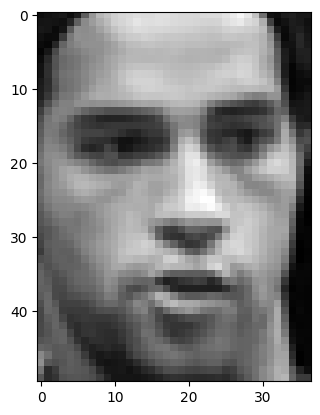

In [6]:
plt.imshow(lfw_people.images[5],cmap='gray')
plt.show()

# Preprocessing:


由于lfw数据集本身已经做了一些数据处理，比如每张图片的尺寸为250X250（shape统一），同时我们调用的数据集也做了灰度化处理来降低复杂度。因此数据预处理上可以做的事情就比较简单，我们可以比较两种数据预处理方法：标准化和归一化。（**可以分别在SVM、CNN上把两种预处理的数据都跑一遍看看结果符不符合预期**）

***标准化*** 

$$X=\frac{X-\mu}{\sigma}$$

作用：使数据均值为 0，方差为 1，适合基于距离的算法（如 SVM、KNN、PCA）。

但代码结果显示mean $\neq$ 0, $std \neq 1$,原因是PCA、SVM等机器学习模型都遵循scikit-learn 的约定，输入数据 X 必须是形状为 (n_samples, n_features) 的 二维数组，*每一行*是一个样本，*每一列*是一个特征值（如人脸图像的一个像素、一个颜色通道等），而实际代码计算的时候是根据特征值进行标准化（按列），即对于每个元素 $X_{ij}$:
$$ X_{ij}=\frac{X_{ij}-\mu_{j}}{\sigma_{j}} $$
而这里的mean和std都是按行（也就是对于一张图片而言）的，所以会存在mean不等于0等现象。

*标准化的特点*:标准化计算中

$$\mu = \frac{1}{n}\sum_{i=1}^n X, \quad \sigma = \sqrt{\frac{1}{n}\sum_{i=1}^n (X-\mu)^2} $$

经过标准化后，对于标准差 $\sigma$ 较大的特征值，由于标准差计算中 $\sigma$ 在分母，会实际缩小这些值的差异，让不同图片中区分度很大的地方（可能是噪声）变平滑；同时，对于标准差 $\sigma$ 较小的特征值，标准差计算会放大这些值的特点，也就是对于图像中相同的或者相似的部分，标准化会增强这一特征（比如图片亮处更亮、暗处更暗）。所以整体上，标准化可以使同一特征值的数据更加一致，数据间的距离和差值更小，因此适合基于距离的算法（如 SVM、KNN、PCA）。

***归一化*** 

$$X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}} $$

作用：将数据线性压缩到固定范围（默认 [0, 1]），适合需要限定输入范围的模型（如神经网络）。

*归一化的特点*：归一化计算中实际上也是对特征进行计算：
$$X_{norm}[:,j] = \frac{X[:,j]-minX[:,j]}{maxX[:,j]-minX[:,j]}$$
这本质上是一种线性变换，数据的分布形状不会产生变化，仅仅是进行缩放和平移（仿射变换），也解释了跑出来的图相较和原图差异不大的现象。
$$X_{norm}=aX+b,\quad a=\frac{1}{X_{max}-X_{min}},\quad b=\frac{-X_{min}}{X_{max}-X_{min}} $$

和Batch Normalization一样，缓解梯度消失/爆炸问题，适用于CNN


=== Sample 2619 (Person: Gloria Macapagal Arroyo) ===


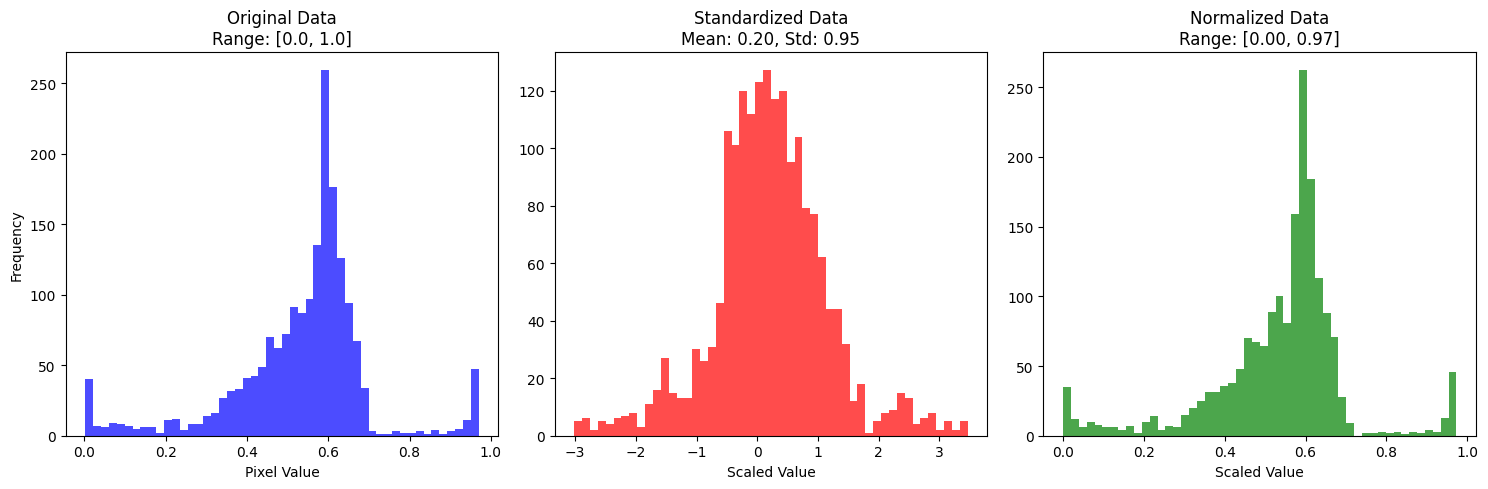

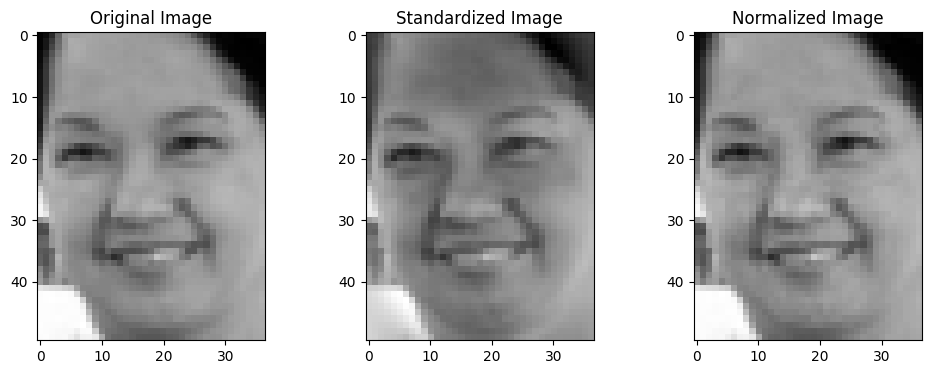


=== Sample 3 (Person: Colin Powell) ===


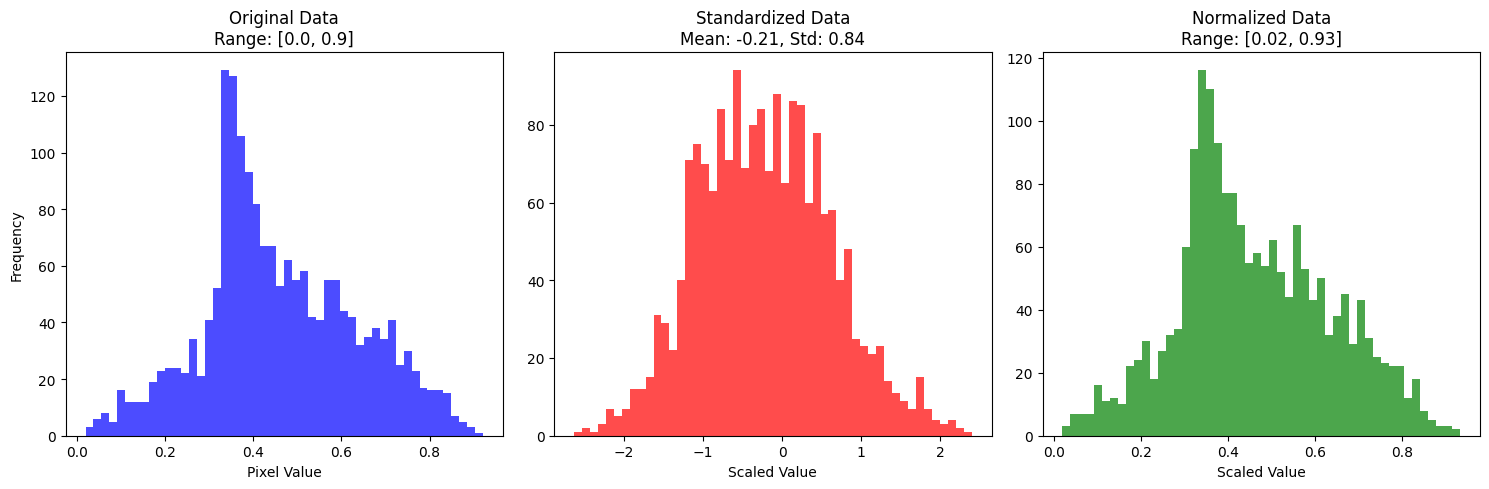

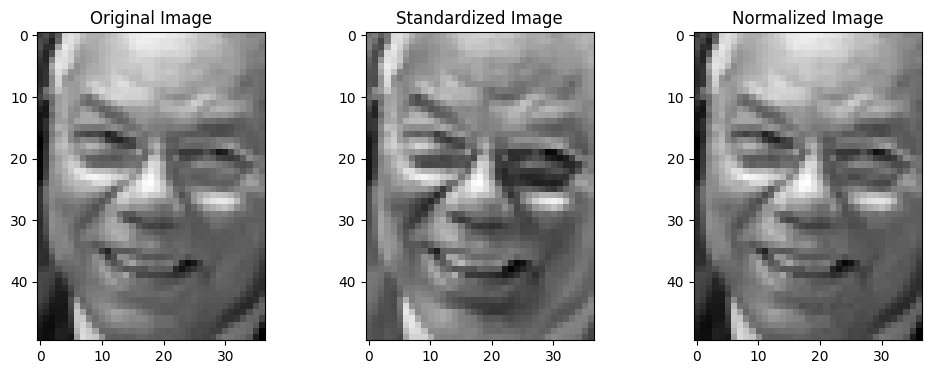


=== Sample 1521 (Person: Jennifer Aniston) ===


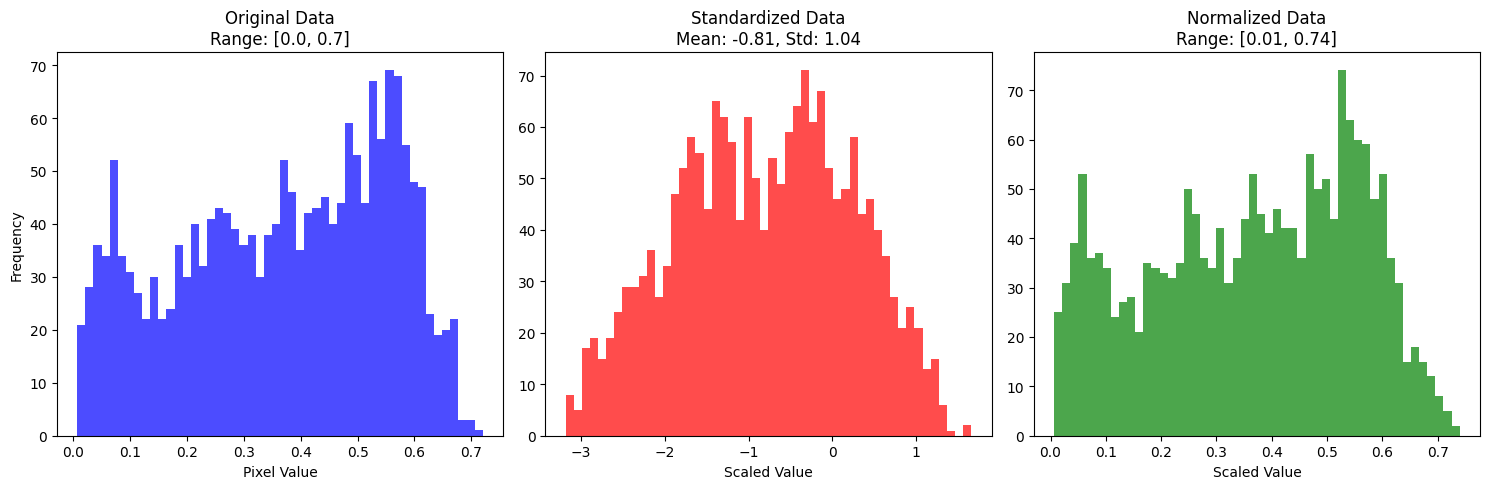

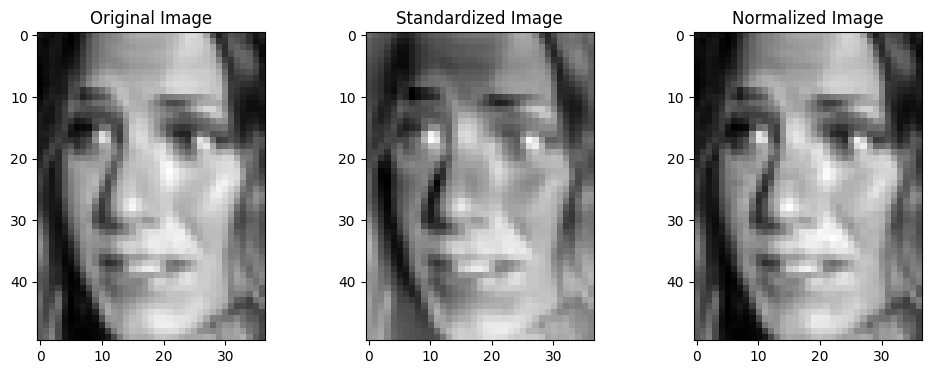


=== Sample 3082 (Person: Renee Zellweger) ===


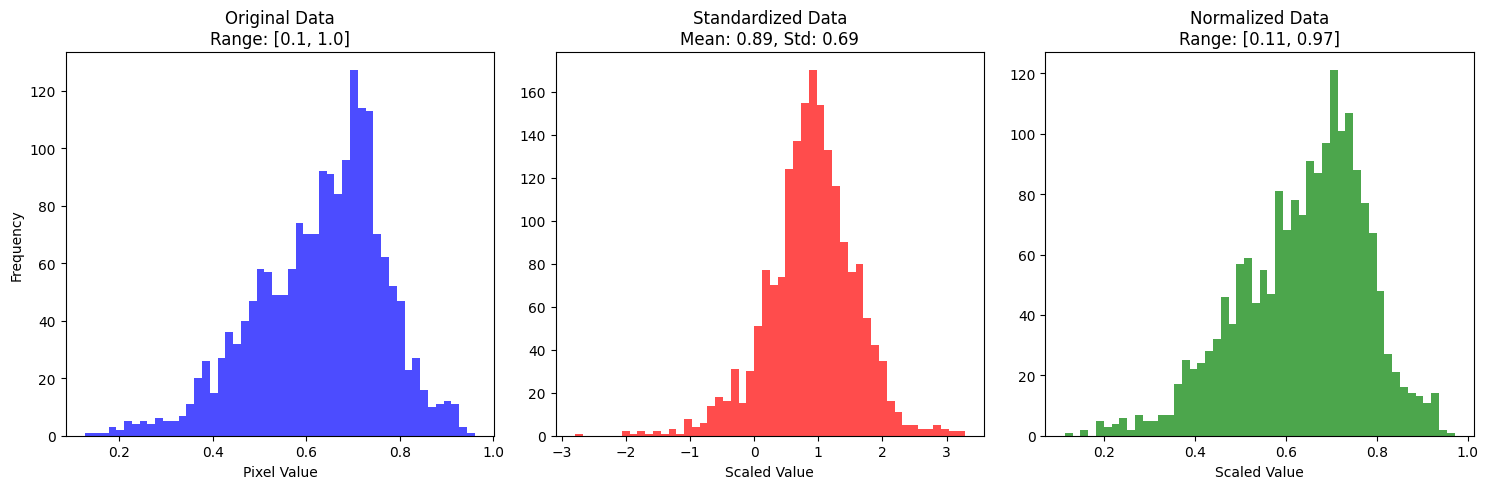

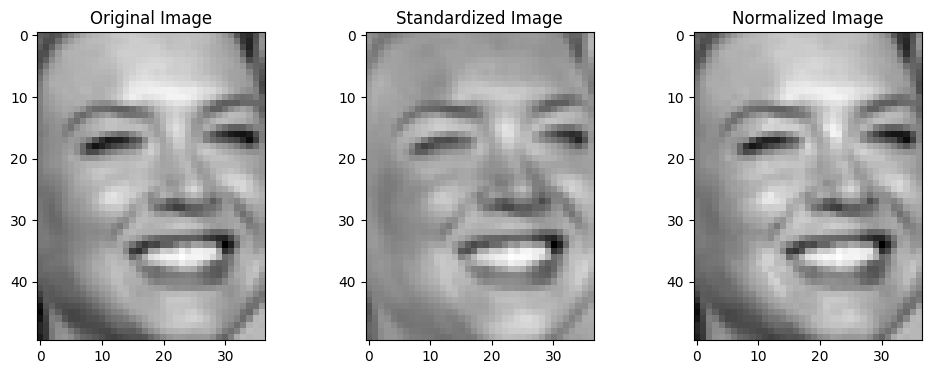


=== Sample 3799 (Person: Kim Clijsters) ===


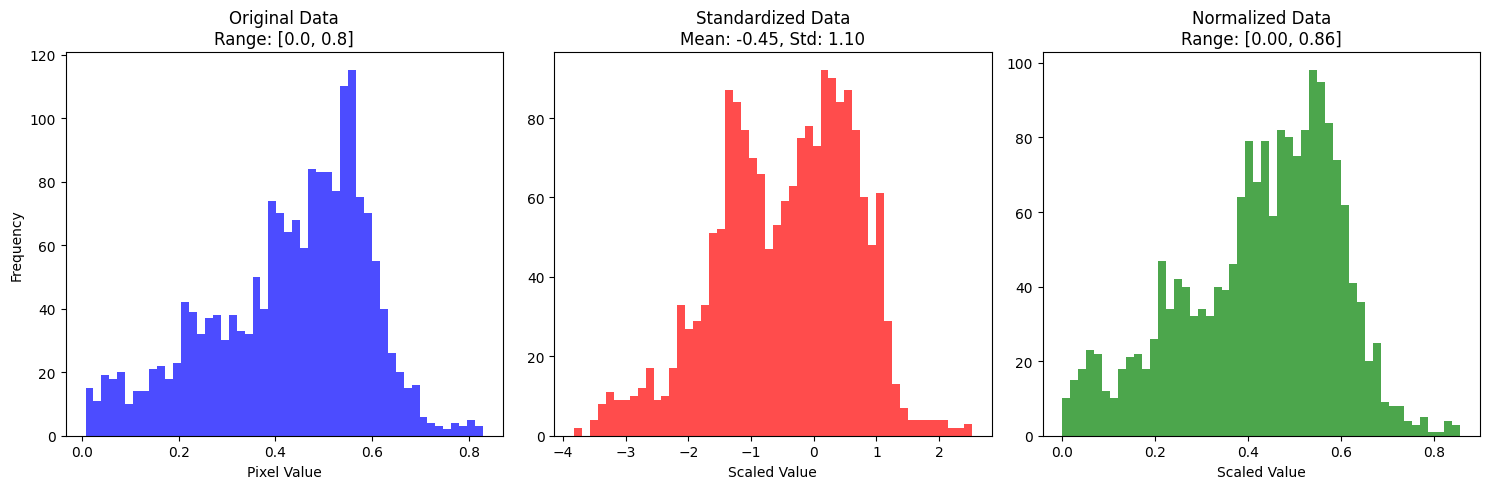

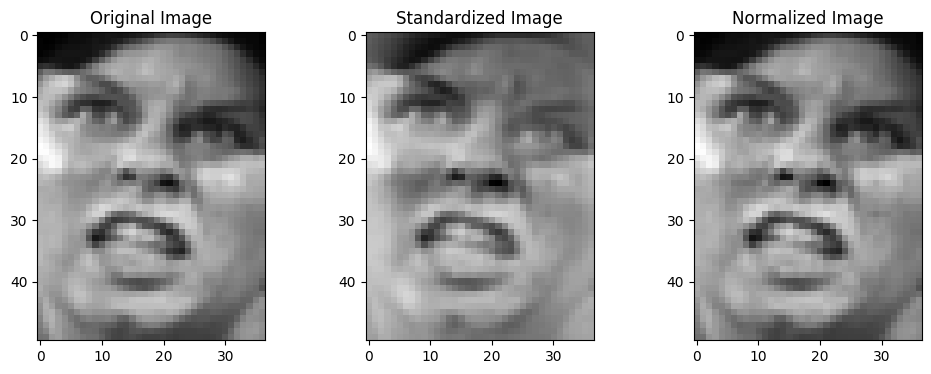

In [7]:
# 2. 预处理
# 标准化
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X)
# 归一化
scaler_norm = MinMaxScaler()
X_norm = scaler_norm.fit_transform(X)

# 3. 可视化分布
def plot_distribution(X_original, X_std, X_norm, sample_idx=0):
    """绘制三种处理方式的分布对比"""
    plt.figure(figsize=(15, 5))
    
    # 原始数据
    plt.subplot(1, 3, 1)
    plt.hist(X_original[sample_idx], bins=50, color='blue', alpha=0.7)
    plt.title(f"Original Data\nRange: [{X_original[sample_idx].min():.1f}, {X_original[sample_idx].max():.1f}]")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    
    # 标准化后
    plt.subplot(1, 3, 2)
    plt.hist(X_std[sample_idx], bins=50, color='red', alpha=0.7)
    plt.title(f"Standardized Data\nMean: {X_std[sample_idx].mean():.2f}, Std: {X_std[sample_idx].std():.2f}")
    plt.xlabel("Scaled Value")
    
    # 归一化后
    plt.subplot(1, 3, 3)
    plt.hist(X_norm[sample_idx], bins=50, color='green', alpha=0.7)
    plt.title(f"Normalized Data\nRange: [{X_norm[sample_idx].min():.2f}, {X_norm[sample_idx].max():.2f}]")
    plt.xlabel("Scaled Value")
    
    plt.tight_layout()
    plt.show()

# 4. 随机选择5个人脸样本对比
for i in np.random.choice(len(X), 5, replace=False):
    print(f"\n=== Sample {i} (Person: {lfw_people.target_names[lfw_people.target[i]]}) ===")
    plot_distribution(X, X_std, X_norm, sample_idx=i)
    
    # 可视化图像对比
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(X[i].reshape(h, w), cmap='gray')
    axes[0].set_title("Original Image")
    axes[1].imshow(X_std[i].reshape(h, w), cmap='gray')
    axes[1].set_title("Standardized Image")
    axes[2].imshow(X_norm[i].reshape(h, w), cmap='gray')
    axes[2].set_title("Normalized Image")
    plt.show()

In [8]:

class_counts = Counter(lfw_people.target)

print("类别分布:", class_counts)

类别分布: Counter({np.int64(35): 530, np.int64(23): 236, np.int64(149): 144, np.int64(29): 121, np.int64(36): 109, np.int64(11): 77, np.int64(49): 71, np.int64(85): 60, np.int64(61): 55, np.int64(73): 53, np.int64(54): 52, np.int64(134): 52, np.int64(153): 49, np.int64(95): 48, np.int64(37): 44, np.int64(65): 42, np.int64(12): 42, np.int64(91): 41, np.int64(93): 41, np.int64(44): 39, np.int64(2): 39, np.int64(110): 37, np.int64(5): 36, np.int64(3): 35, np.int64(137): 33, np.int64(99): 33, np.int64(146): 33, np.int64(152): 32, np.int64(89): 32, np.int64(129): 32, np.int64(77): 31, np.int64(25): 31, np.int64(122): 30, np.int64(41): 30, np.int64(14): 29, np.int64(97): 29, np.int64(52): 28, np.int64(82): 28, np.int64(124): 27, np.int64(131): 26, np.int64(40): 26, np.int64(144): 25, np.int64(13): 24, np.int64(156): 24, np.int64(68): 24, np.int64(81): 23, np.int64(141): 23, np.int64(132): 23, np.int64(92): 22, np.int64(34): 22, np.int64(119): 22, np.int64(43): 22, np.int64(109): 22, np.int64(4):

样本量在10-30之间的类别及数量:
类别 Abdullah Gul: 19 个样本
类别 James Blake: 14 个样本
类别 Yoriko Kawaguchi: 14 个样本
类别 Mohammed Al-Douri: 15 个样本
类别 Bill Simon: 15 个样本
类别 Dominique de Villepin: 15 个样本
类别 John Kerry: 17 个样本
类别 Lindsay Davenport: 22 个样本
类别 Catherine Zeta-Jones: 11 个样本
类别 Andy Roddick: 15 个样本
类别 Jose Maria Aznar: 23 个样本
类别 James Kelly: 11 个样本
类别 Atal Bihari Vajpayee: 24 个样本
类别 Winona Ryder: 24 个样本
类别 Roger Federer: 14 个样本
类别 Paul Wolfowitz: 10 个样本
类别 Rudolph Giuliani: 26 个样本
类别 Richard Gephardt: 11 个样本
类别 Javier Solana: 10 个样本
类别 Keanu Reeves: 12 个样本
类别 David Nalbandian: 14 个样本
类别 George Robertson: 22 个样本
类别 Kim Ryong-sung: 11 个样本
类别 Spencer Abraham: 17 个样本
类别 Ricardo Lagos: 27 个样本
类别 Jeb Bush: 12 个样本
类别 Jiri Novak: 11 个样本
类别 Hillary Clinton: 14 个样本
类别 Richard Myers: 18 个样本
类别 Nicanor Duarte Frutos: 11 个样本
类别 Michael Jackson: 12 个样本
类别 Halle Berry: 16 个样本
类别 Walter Mondale: 10 个样本
类别 Amelie Mauresmo: 21 个样本
类别 Bill Clinton: 29 个样本
类别 Pete Sampras: 22 个样本
类别 Howard Dean: 12 个样本
类别 Jeremy Greenst

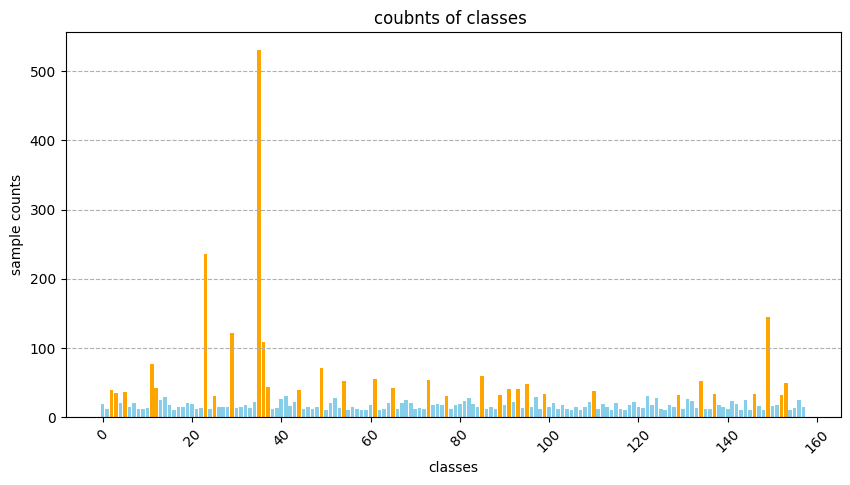

In [9]:
rare_classes = {cls: count for cls, count in class_counts.items() if 10 <= count <= 30}
ma_classes = {cls: count for cls, count in class_counts.items() if count > 30}
print("样本量在10-30之间的类别及数量:")
for cls, count in rare_classes.items():
    print(f"类别 {target_names[cls]}: {count} 个样本")
print("样本量大于30的类别及数量:")
for cls, count in ma_classes.items():
    print(f"类别 {target_names[cls]}: {count} 个样本")


# 提取类别和样本数
rclasses = list(rare_classes.keys())
rcounts = list(rare_classes.values())
mclasses= list(ma_classes.keys())
mcounts = list(ma_classes.values())

# 绘制条形图
plt.figure(figsize=(10, 5))
plt.bar(rclasses, rcounts, color='skyblue')
plt.bar(mclasses, mcounts, color='orange')

plt.xlabel("classes")
plt.ylabel("sample counts")
plt.title("coubnts of classes ")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

In [10]:
X_rare,y_rare,X_rare_train,y_rare_train,X_rare_test,y_rare_test = [],[],[],[],[],[]
X_ma,y_ma,X_ma_train,y_ma_train,X_ma_test,y_ma_test = [],[],[],[],[],[]
#rare_classes = {cls: count for cls, count in class_counts.items() if 10 <= count <= 30}
for cls in rclasses:
    cls_id=np.where(lfw_people.target==cls)[0]
    X_rare.append(lfw_people.data[cls_id])
    y_rare.append(lfw_people.target[cls_id])

X_rare = np.concatenate(X_rare)
y_rare = np.concatenate(y_rare)
X_rare_train, X_rare_test, y_rare_train, y_rare_test = train_test_split(X_rare, y_rare, test_size=0.25)
#ma_classes = {cls: count for cls, count in class_counts.items() if count > 30}
for cls in mclasses:
    cls_id=np.where(lfw_people.target==cls)[0]
    X_ma.append(lfw_people.data[cls_id])
    y_ma.append(lfw_people.target[cls_id])

X_ma = np.concatenate(X_ma)
y_ma = np.concatenate(y_ma)    
X_ma_train, X_ma_test, y_ma_train, y_ma_test = train_test_split(X_ma, y_ma, test_size=0.25)

print("Rare classes train and test sets:")
print("X_rare shape:", X_rare.shape)
print("y_rare shape:", y_rare.shape)
print("X_ma shape:", X_ma.shape)
print("y_ma shape:", y_ma.shape)
print("X_rare_train shape:", X_rare_train.shape)
print("Unique classes in y_rare_train:", len(np.unique(y_rare_train)))
print("X_ma_train shape:", X_ma_train.shape)
print("Unique classes in y_ma_train:", len(np.unique(y_ma_train)))
print("X_rare_test shape:", X_rare_test.shape)
print("Unique classes in y_rare_test:", len(np.unique(y_rare_test)))
print("X_ma_test shape:", X_ma_test.shape)
print("Unique classes in y_ma_test:", len(np.unique(y_ma_test)))
print("Length of target_names:", len(lfw_people.target_names))

Rare classes train and test sets:
X_rare shape: (2014, 1850)
y_rare shape: (2014,)
X_ma shape: (2310, 1850)
y_ma shape: (2310,)
X_rare_train shape: (1510, 1850)
Unique classes in y_rare_train: 126
X_ma_train shape: (1732, 1850)
Unique classes in y_ma_train: 32
X_rare_test shape: (504, 1850)
Unique classes in y_rare_test: 124
X_ma_test shape: (578, 1850)
Unique classes in y_ma_test: 32
Length of target_names: 158


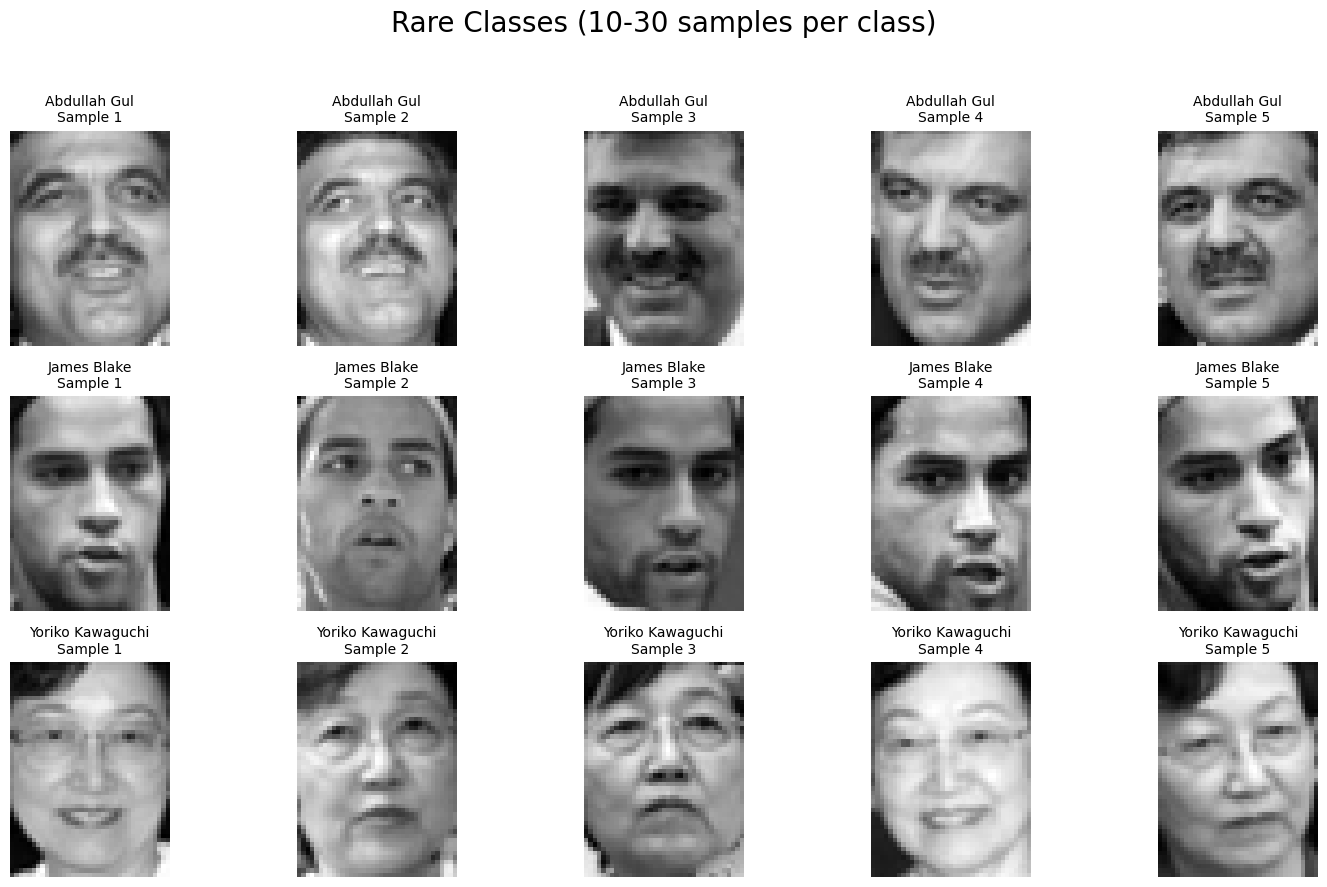

In [11]:


n_samples_to_show = 5  # 每个类别显示5张图片
max_classes_to_show = 3  # 最多显示3个稀有类别

# 获取要展示的类别
rare_class_items = list(rare_classes.items())[:max_classes_to_show]

# 设置画布尺寸：每行 5 张图，图像大一些
fig, axes = plt.subplots(len(rare_class_items), n_samples_to_show, figsize=(n_samples_to_show * 3, len(rare_class_items) * 3))
fig.suptitle("Rare Classes (10-30 samples per class)", fontsize=20)

for i, (cls, count) in enumerate(rare_class_items):
    cls_indices = np.where(y == cls)[0]
    selected_indices = np.random.choice(cls_indices, size=min(n_samples_to_show, len(cls_indices)), replace=False)
    
    for j in range(n_samples_to_show):
        ax = axes[i][j] if len(rare_class_items) > 1 else axes[j]  # 兼容1行的情况
        
        if j < len(selected_indices):
            idx = selected_indices[j]
            ax.imshow(lfw_people.images[idx], cmap='gray')
            ax.set_title(f"{target_names[cls]}\nSample {j+1}", fontsize=10)
        else:
            ax.axis('off')  # 没有足够样本时隐藏多余子图

        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # 留出标题位置
plt.show()



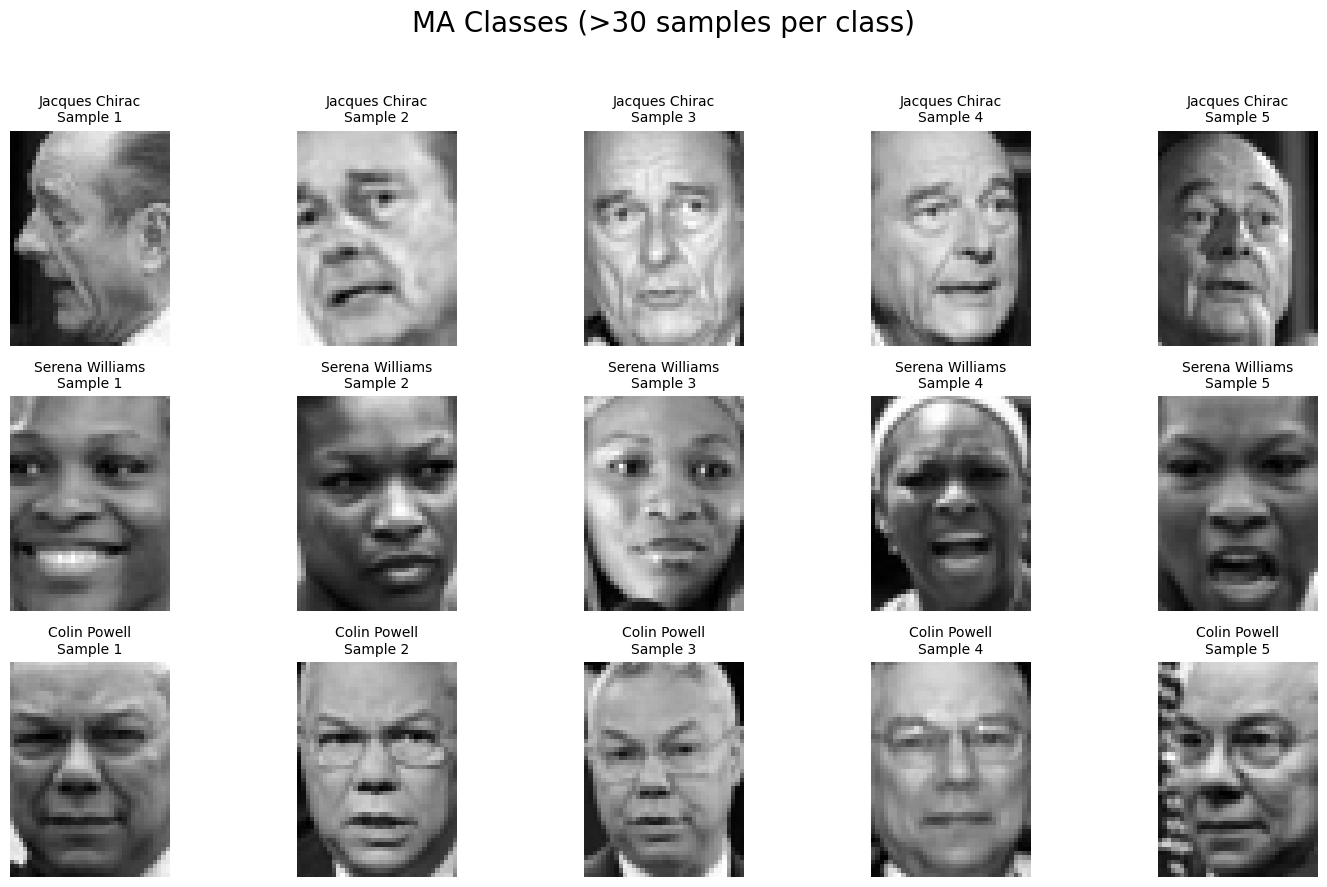

In [12]:

ma_class_items = list(ma_classes.items())[:max_classes_to_show]

# 创建子图：每行 5 张图像
fig, axes = plt.subplots(len(ma_class_items), n_samples_to_show, figsize=(n_samples_to_show * 3, len(ma_class_items) * 3))
fig.suptitle("MA Classes (>30 samples per class)", fontsize=20)

for i, (cls, count) in enumerate(ma_class_items):
    cls_indices = np.where(y == cls)[0]
    selected_indices = np.random.choice(cls_indices, size=min(n_samples_to_show, len(cls_indices)), replace=False)

    for j in range(n_samples_to_show):
        ax = axes[i][j] if len(ma_class_items) > 1 else axes[j]  # 兼容仅1行的情况

        if j < len(selected_indices):
            idx = selected_indices[j]
            ax.imshow(lfw_people.images[idx], cmap='gray')
            ax.set_title(f"{target_names[cls]}\nSample {j+1}", fontsize=10)
        else:
            ax.axis('off')  # 不足5张样本时隐藏多余子图

        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # 留出标题位置
plt.show()


In [13]:
from sklearn.preprocessing import StandardScaler
#标准化操作
scaler = StandardScaler()
X_rare_train = scaler.fit_transform(X_rare_train)
X_rare_test = scaler.transform(X_rare_test)
X_ma_train = scaler.fit_transform(X_ma_train)
X_ma_test = scaler.transform(X_ma_test)

## Using SVC only

In [14]:
model = SVC(kernel='rbf',class_weight='balanced')
model.fit(X_rare_train,y_rare_train)

SVC(class_weight='balanced')

In [15]:
predictions=model.predict(X_rare_test)

labels_in_use = np.unique(np.concatenate([y_rare_test, predictions]))
target_names_filtered = [lfw_people.target_names[i] for i in labels_in_use]

# 打印分类报告
print(classification_report(y_rare_test, predictions,
                            labels=labels_in_use,
                            target_names=target_names_filtered,
                            zero_division=0))


                           precision    recall  f1-score   support

             Abdullah Gul       0.67      0.29      0.40         7
             Adrien Brody       0.00      0.00      0.00         3
          Amelie Mauresmo       0.33      0.33      0.33         3
             Andy Roddick       0.50      0.20      0.29         5
           Angelina Jolie       0.60      0.43      0.50         7
              Ann Veneman       0.14      0.50      0.22         2
          Anna Kournikova       1.00      0.33      0.50         3
            Ari Fleischer       0.00      0.00      0.00         1
     Atal Bihari Vajpayee       0.14      0.50      0.22         4
             Bill Clinton       0.00      0.00      0.00        10
               Bill Gates       1.00      0.33      0.50         6
             Bill McBride       0.00      0.00      0.00         2
               Bill Simon       0.00      0.00      0.00         4
           Britney Spears       0.67      0.29      0.40     

In [16]:
model = SVC(kernel='rbf',class_weight='balanced')
model.fit(X_ma_train,y_ma_train)
predictions=model.predict(X_ma_test)

labels_in_use = np.unique(np.concatenate([y_ma_test, predictions]))
target_names_filtered = [lfw_people.target_names[i] for i in labels_in_use]

# 打印分类报告
print(classification_report(y_ma_test, predictions,
                            labels=labels_in_use,
                            target_names=target_names_filtered,
                            zero_division=0))

                           precision    recall  f1-score   support

         Alejandro Toledo       0.50      0.33      0.40        15
             Alvaro Uribe       0.40      1.00      0.57         4
             Andre Agassi       1.00      0.25      0.40        12
             Ariel Sharon       0.78      0.58      0.67        24
    Arnold Schwarzenegger       0.27      0.29      0.28        14
             Colin Powell       0.67      0.67      0.67        60
            David Beckham       0.18      0.50      0.26         6
          Donald Rumsfeld       0.52      0.54      0.53        24
            George W Bush       0.72      0.55      0.63       132
        Gerhard Schroeder       0.34      0.48      0.40        25
  Gloria Macapagal Arroyo       0.67      0.57      0.62         7
                Hans Blix       0.56      0.42      0.48        12
              Hugo Chavez       0.43      0.40      0.41        15
           Jacques Chirac       0.41      0.47      0.44     

# PCA

In [17]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

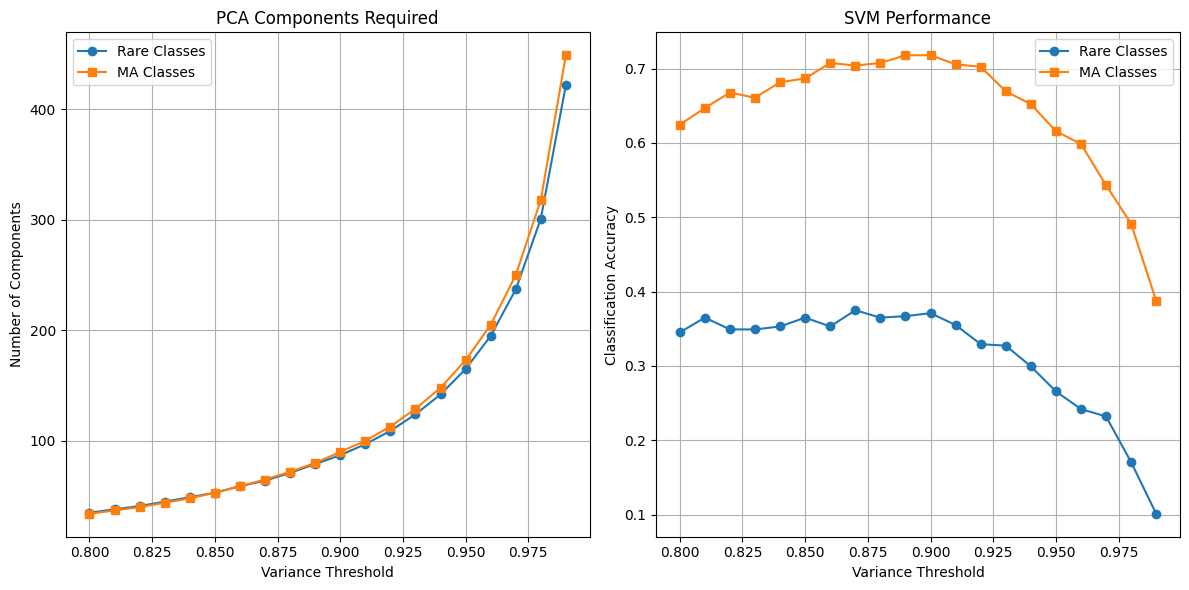

Rare Classes Results:
Threshold 0.80: 35 components, Accuracy=0.3452
Threshold 0.81: 38 components, Accuracy=0.3651
Threshold 0.82: 41 components, Accuracy=0.3492
Threshold 0.83: 45 components, Accuracy=0.3492
Threshold 0.84: 49 components, Accuracy=0.3532
Threshold 0.85: 53 components, Accuracy=0.3651
Threshold 0.86: 59 components, Accuracy=0.3532
Threshold 0.87: 64 components, Accuracy=0.3750
Threshold 0.88: 71 components, Accuracy=0.3651
Threshold 0.89: 79 components, Accuracy=0.3671
Threshold 0.90: 87 components, Accuracy=0.3710
Threshold 0.91: 97 components, Accuracy=0.3552
Threshold 0.92: 109 components, Accuracy=0.3294
Threshold 0.93: 124 components, Accuracy=0.3274
Threshold 0.94: 142 components, Accuracy=0.2996
Threshold 0.95: 165 components, Accuracy=0.2659
Threshold 0.96: 195 components, Accuracy=0.2421
Threshold 0.97: 237 components, Accuracy=0.2321
Threshold 0.98: 301 components, Accuracy=0.1706
Threshold 0.99: 422 components, Accuracy=0.1012

MA Classes Results:
Threshold

In [21]:


# 设置方差阈值列表和存储结果的字典
variance_thresholds = np.linspace(0.8, 0.99, 20)
results = {
    'rare': {'n_components': [], 'accuracy': []},
    'ma': {'n_components': [], 'accuracy': []}
}

# 定义评估函数
def evaluate_pca_svm(X_train, X_test, y_train, y_test, dataset_type):
    pca_full = PCA().fit(X_train)
    cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)
    
    for threshold in variance_thresholds:
        # 计算所需主成分数
        n_components = np.argmax(cumulative_var >= threshold) + 1
        results[dataset_type]['n_components'].append(n_components)
        
        # PCA降维
        pca = PCA(n_components=n_components, whiten=True)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        # 训练SVM并评估
        model = SVC(kernel='rbf', class_weight='balanced')
        model.fit(X_train_pca, y_train)
        pred = model.predict(X_test_pca)
        acc = accuracy_score(y_test, pred)
        results[dataset_type]['accuracy'].append(acc)

# 对rare和ma数据集分别评估
evaluate_pca_svm(X_rare_train, X_rare_test, y_rare_train, y_rare_test, 'rare')
evaluate_pca_svm(X_ma_train, X_ma_test, y_ma_train, y_ma_test, 'ma')

# 可视化结果
plt.figure(figsize=(12, 6))

# 主成分数量对比
plt.subplot(1, 2, 1)
plt.plot(variance_thresholds, results['rare']['n_components'], 'o-', label='Rare Classes')
plt.plot(variance_thresholds, results['ma']['n_components'], 's-', label='MA Classes')
plt.xlabel('Variance Threshold')
plt.ylabel('Number of Components')
plt.title('PCA Components Required')
plt.legend()
plt.grid(True)

# 分类准确度对比
plt.subplot(1, 2, 2)
plt.plot(variance_thresholds, results['rare']['accuracy'], 'o-', label='Rare Classes')
plt.plot(variance_thresholds, results['ma']['accuracy'], 's-', label='MA Classes')
plt.xlabel('Variance Threshold')
plt.ylabel('Classification Accuracy')
plt.title('SVM Performance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 打印详细结果
print("Rare Classes Results:")
for i, thresh in enumerate(variance_thresholds):
    print(f"Threshold {thresh:.2f}: {results['rare']['n_components'][i]} components, Accuracy={results['rare']['accuracy'][i]:.4f}")

print("\nMA Classes Results:")
for i, thresh in enumerate(variance_thresholds):
    print(f"Threshold {thresh:.2f}: {results['ma']['n_components'][i]} components, Accuracy={results['ma']['accuracy'][i]:.4f}")

print(f"Max accuracy for rare classes:{ max(results['rare']['accuracy'])},n_components:{results['rare']['n_components'][np.argmax(results['rare']['accuracy'])]}")
print("Max accuracy for ma classes:", max(results['ma']['accuracy']))
print(f"Max accuracy for ma classes:{ max(results['ma']['accuracy'])},n_components:{results['ma']['n_components'][np.argmax(results['ma']['accuracy'])]}")

In [22]:
from sklearn.preprocessing import StandardScaler

n_components=64
pca=PCA(n_components=n_components,whiten=True).fit(X_rare_train)
#x_all_pca=pca.transform(lfw_people.data)
X_rare_train_pca=pca.fit_transform(X_rare_train)
X_rare_test_pca=pca.transform(X_rare_test)
model = SVC(kernel='rbf', class_weight='balanced')
model.fit(X_rare_train_pca, y_rare_train)
pred = model.predict(X_rare_test_pca)
acc = accuracy_score(y_rare_test, pred)
# 打印分类报告
print("Rare classes accuracy:", acc)
print(f"Final Accuracy with {n_components} components: {acc:.4f}")
labels_in_use = np.unique(np.concatenate([y_rare_test, pred]))
target_names_filtered = [lfw_people.target_names[i] for i in labels_in_use]
print(classification_report(y_rare_test, pred,
                            labels=labels_in_use,
                            target_names=target_names_filtered,
                            zero_division=0))

eigenfaces_rare = pca.components_.reshape((64, h, w))



Rare classes accuracy: 0.36706349206349204
Final Accuracy with 64 components: 0.3671
                           precision    recall  f1-score   support

             Abdullah Gul       0.50      0.57      0.53         7
             Adrien Brody       1.00      0.33      0.50         3
          Amelie Mauresmo       0.00      0.00      0.00         3
             Andy Roddick       1.00      0.20      0.33         5
           Angelina Jolie       0.75      0.43      0.55         7
              Ann Veneman       0.50      0.50      0.50         2
          Anna Kournikova       1.00      0.33      0.50         3
            Ari Fleischer       0.33      1.00      0.50         1
     Atal Bihari Vajpayee       1.00      0.75      0.86         4
             Bill Clinton       0.80      0.40      0.53        10
               Bill Gates       0.40      0.33      0.36         6
             Bill McBride       0.00      0.00      0.00         2
               Bill Simon       1.00      0

In [23]:

pca = PCA(n_components=80, whiten=True)
X_ma_train_pca = pca.fit_transform(X_ma_train)
X_ma_test_pca = pca.transform(X_ma_test)

# 训练SVM并评估
model = SVC(kernel='rbf', class_weight='balanced')
model.fit(X_ma_train_pca, y_ma_train)
pred = model.predict(X_ma_test_pca)
acc = accuracy_score(y_ma_test, pred)
# 打印分类报告
labels_in_use = np.unique(np.concatenate([y_ma_test, pred]))
target_names_filtered = [lfw_people.target_names[i] for i in labels_in_use]
print(classification_report(y_ma_test, predictions,
                            labels=labels_in_use,
                            target_names=target_names_filtered,
                            zero_division=0))
print("MA classes accuracy:", acc)
print(f"Final Accuracy with 101 components: {acc:.4f}")

eigenfaces_ma = pca.components_.reshape((80, h, w))





                           precision    recall  f1-score   support

         Alejandro Toledo       0.50      0.33      0.40        15
             Alvaro Uribe       0.40      1.00      0.57         4
             Andre Agassi       1.00      0.25      0.40        12
             Ariel Sharon       0.78      0.58      0.67        24
    Arnold Schwarzenegger       0.27      0.29      0.28        14
             Colin Powell       0.67      0.67      0.67        60
            David Beckham       0.18      0.50      0.26         6
          Donald Rumsfeld       0.52      0.54      0.53        24
            George W Bush       0.72      0.55      0.63       132
        Gerhard Schroeder       0.34      0.48      0.40        25
  Gloria Macapagal Arroyo       0.67      0.57      0.62         7
                Hans Blix       0.56      0.42      0.48        12
              Hugo Chavez       0.43      0.40      0.41        15
           Jacques Chirac       0.41      0.47      0.44     

Rare classes eigenfaces:
MA classes eigenfaces:


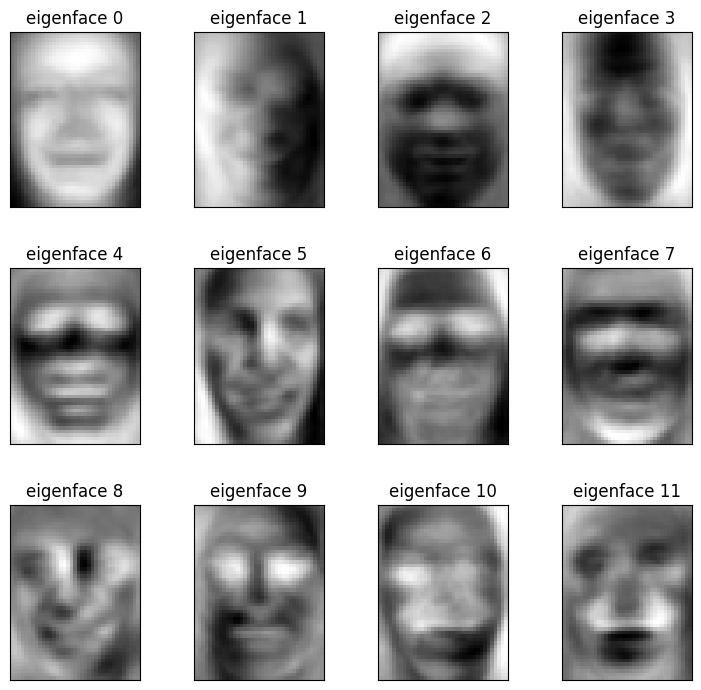

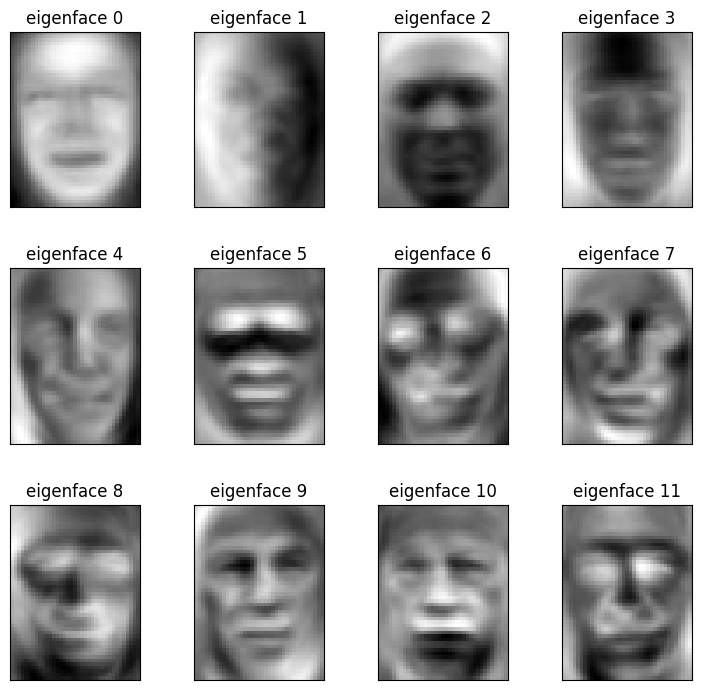

In [24]:


eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces_rare.shape[0])]
plot_gallery(eigenfaces_rare, eigenface_titles, h, w)
print("Rare classes eigenfaces:")
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces_ma.shape[0])]
plot_gallery(eigenfaces_ma, eigenface_titles, h, w)
print("MA classes eigenfaces:")
plt.show()

# diff_pc = np.argmax(np.sum(np.abs(eigenfaces_rare - eigenfaces_ma), axis=(1, 2)))
# plt.imshow(eigenfaces_rare[diff_pc] - eigenfaces_ma[diff_pc], cmap='seismic')
# plt.colorbar()
# plt.title(f'diff max(PC{diff_pc+1})')
# plt.show()

## 调参 好难 

In [ ]:
param_grid={'C':[1e-3,1e-2,1e-1,1,10,100],
           'gamma':[0.0005,0.001,0.005,0.01],}

model=GridSearchCV(SVC(kernel='rbf',class_weight='balanced'),param_grid)
#传入param_grid之后会使用所有C和gamma参数的组合
model.fit(X_rare_train_pca,y_rare_train)
print(model.best_estimator_)


c:\Users\ASUS\anaconda3\envs\CS182\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:

param_grid={'C':[50,80,100,500,1000],
           'gamma':[0.0005,0.001,0.005,0.01],}

model=GridSearchCV(SVC(kernel='rbf',class_weight='balanced'),param_grid)
#传入param_grid之后会使用所有C和gamma参数的组合
model.fit(X_rare_train_pca,y_rare_train)
print(model.best_estimator_)

SVC(C=50, class_weight='balanced', gamma=0.001)


In [ ]:
param_grid={'C':[30,40,50,80,60],
           'gamma':[0.0006,0.001,0.002,0.003],}
model=GridSearchCV(SVC(kernel='rbf',class_weight='balanced'),param_grid)
#传入param_grid之后会使用所有C和gamma参数的组合
model.fit(X_rare_train_pca,y_rare_train)
print(model.best_estimator_)

SVC(C=30, class_weight='balanced', gamma=0.002)


In [ ]:
param_grid={'C':[20,25,30,35,40],
           'gamma':[0.001,0.0015,0.002,0.0025],}
model=GridSearchCV(SVC(kernel='rbf',class_weight='balanced'),param_grid)
#传入param_grid之后会使用所有C和gamma参数的组合
model.fit(X_rare_train_pca,y_rare_train)
print(model.best_estimator_)


SVC(C=20, class_weight='balanced', gamma=0.002)


In [ ]:
param_grid={'C':[10,13,16,20,23,25],
           'gamma':[0.001,0.0015,0.002,0.0025],}
model=GridSearchCV(SVC(kernel='rbf',class_weight='balanced'),param_grid)
#传入param_grid之后会使用所有C和gamma参数的组合
model.fit(X_rare_train_pca,y_rare_train)
print(model.best_estimator_)

SVC(C=10, class_weight='balanced', gamma=0.002)


In [ ]:
param_grid={'C':[5,6,7,8,10],
           'gamma':[0.001,0.0015,0.002],}
model=GridSearchCV(SVC(kernel='rbf',class_weight='balanced'),param_grid)
#传入param_grid之后会使用所有C和gamma参数的组合
model.fit(X_rare_train_pca,y_rare_train)
print(model.best_estimator_)

SVC(C=7, class_weight='balanced', gamma=0.0015)


In [ ]:

%pip install scikit-optimize

from skopt import BayesSearchCV
from skopt.space import Real

opt = BayesSearchCV(
    SVC(kernel='rbf', class_weight='balanced'),
    {
        'C': Real(1, 100, prior='log-uniform'),
        'gamma': Real(0.0001, 0.01, prior='log-uniform')
    },
    n_iter=1000,  # 迭代次数
    cv=3,
    n_jobs=-1
)
opt.fit(X_rare_train_pca, y_rare_train)
print(opt.best_params_)

Note: you may need to restart the kernel to use updated packages.


KeyboardInterrupt: 

In [ ]:
predictions=opt.predict(X_rare_test_pca)

labels_in_use = np.unique(np.concatenate([y_rare_test, predictions]))
target_names_filtered = [lfw_people.target_names[i] for i in labels_in_use]

# 打印分类报告
print(classification_report(y_rare_test, predictions,
                            labels=labels_in_use,
                            target_names=target_names_filtered,
                            zero_division=0))

                           precision    recall  f1-score   support

             Abdullah Gul       1.00      0.20      0.33         5
             Adrien Brody       0.67      1.00      0.80         2
          Amelie Mauresmo       0.38      0.50      0.43         6
             Andy Roddick       0.20      0.33      0.25         3
           Angelina Jolie       0.33      0.80      0.47         5
              Ann Veneman       0.75      1.00      0.86         3
          Anna Kournikova       0.25      0.33      0.29         3
            Ari Fleischer       0.50      0.25      0.33         4
     Atal Bihari Vajpayee       0.45      0.62      0.53         8
             Bill Clinton       0.06      0.20      0.09         5
               Bill Gates       0.00      0.00      0.00         3
             Bill McBride       0.00      0.00      0.00         3
               Bill Simon       0.00      0.00      0.00         0
           Britney Spears       1.00      0.75      0.86     

In [ ]:

X_rare_train_pca=np.array(X_rare_train_pca)
y_rare_train=np.array(lfw_people.target)

## With Cross-Validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cross_validate_with_accuracy(X, y, model, n_splits=5):
    """
    实现交叉验证并在每个fold输出准确率
    
    参数:
    - X: 特征数据
    - y: 标签数据
    - model: SVC
    - n_splits: 交叉验证的折数
    
    返回:
    - 平均准确率
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
        scaler = StandardScaler()
        X_train, X_test = X[train_idx], X[test_idx]
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        
        print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    
    avg_accuracy = np.mean(accuracies)
    print(f"\nAverage Accuracy: {avg_accuracy:.4f}")
    return avg_accuracy

# 示例调用
model = SVC(kernel='rbf', class_weight='balanced', C=7, gamma=0.007)  # 使用之前调参的最佳参数

cross_validate_with_accuracy(X, y, model, n_splits=10)

Fold 1: Accuracy = 0.7885
Fold 2: Accuracy = 0.8269
Fold 3: Accuracy = 0.7244
Fold 4: Accuracy = 0.7821
Fold 5: Accuracy = 0.8590
Fold 6: Accuracy = 0.7692
Fold 7: Accuracy = 0.8141
Fold 8: Accuracy = 0.7949
Fold 9: Accuracy = 0.8077
Fold 10: Accuracy = 0.8205

Average Accuracy: 0.7987


np.float64(0.7987179487179488)

In [ ]:
predictions=model.predict(x_test_pca)
print(classification_report(y_test,predictions,target_names=lfw_people.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.94      0.97        16
     Colin Powell       0.96      0.96      0.96        54
  Donald Rumsfeld       0.95      0.98      0.96        41
    George W Bush       0.98      0.95      0.96       131
Gerhard Schroeder       0.89      1.00      0.94        25
      Hugo Chavez       1.00      1.00      1.00        14
   Jacques Chirac       1.00      0.93      0.96        14
    Jean Chretien       1.00      1.00      1.00        17
    John Ashcroft       0.91      1.00      0.95        10
Junichiro Koizumi       1.00      1.00      1.00        15
  Serena Williams       0.94      1.00      0.97        15
       Tony Blair       0.97      0.97      0.97        38

         accuracy                           0.97       390
        macro avg       0.97      0.98      0.97       390
     weighted avg       0.97      0.97      0.97       390



# 画图

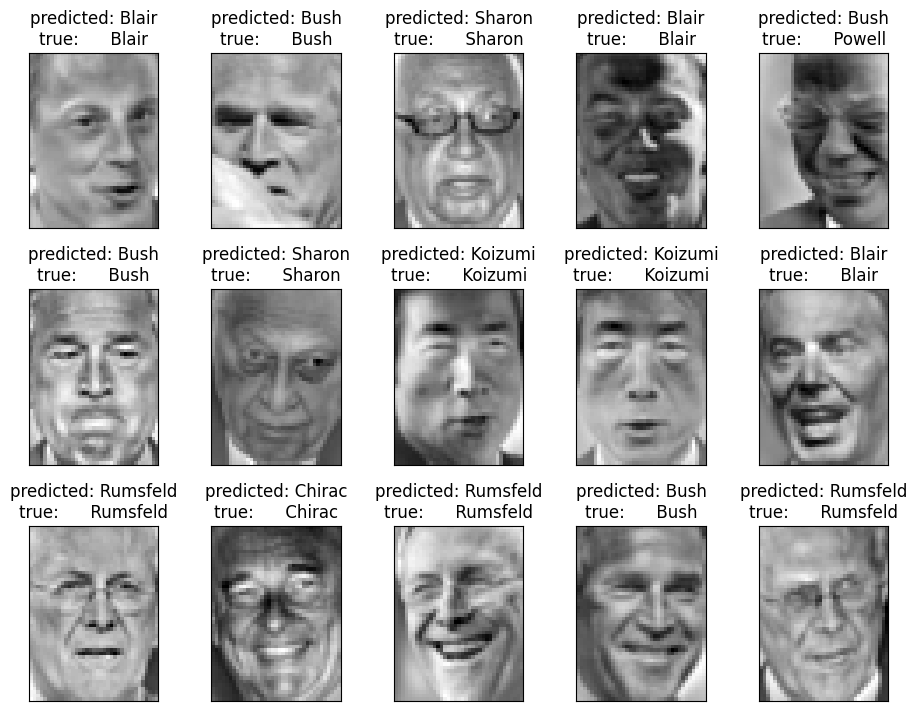

In [ ]:
def plot_gallery(images, titles, h, w, n_rows=3, n_cols=5):
    plt.figure(figsize=(1.8 * n_cols, 2.4 * n_rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)  # 修正：n_rows 和 i+1（整数索引）
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(prediction, true_label, target_names):
    pred_name = target_names[prediction].split(' ')[-1]
    true_name = target_names[true_label].split(' ')[-1]
    return f'predicted: {pred_name}\ntrue:      {true_name}'

# 修正：传入 predictions[i] 和 y_test[i] 作为参数
prediction_titles = [title(predictions[i], y_test[i], target_names) for i in range(len(predictions))]
plot_gallery(x_test, prediction_titles, h, w)
plt.show()